# Fitbit Data Analysis 🏃‍♂️📊
# STEPS

In [1]:
import json
import gzip
import pandas as pd
from datetime import datetime, timedelta
import boto3
from io import BytesIO

In [2]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.dates import DateFormatter
import seaborn as sns

#### =============================================================================
## Bucket

In [3]:
session = boto3.Session(profile_name='surface')
s3 = session.client('s3')

In [4]:
bucket_name = 'followcrom'
prefix = 'cromwell/fitbit/'

#### =============================================================================
## Files

In [5]:
s3response = s3.list_objects_v2(Bucket=bucket_name, Prefix=prefix)
files = [obj['Key'] for obj in s3response.get('Contents', [])]
files

['cromwell/fitbit/',
 'cromwell/fitbit/fitbit_backup_2025-10-03.json.gz',
 'cromwell/fitbit/fitbit_backup_2025-10-04.json.gz',
 'cromwell/fitbit/fitbit_backup_2025-10-05.json.gz',
 'cromwell/fitbit/fitbit_backup_2025-10-06.json.gz',
 'cromwell/fitbit/fitbit_backup_2025-10-07.json.gz',
 'cromwell/fitbit/fitbit_backup_2025-10-08.json.gz',
 'cromwell/fitbit/fitbit_backup_2025-10-09.json.gz',
 'cromwell/fitbit/fitbit_backup_2025-10-10.json.gz',
 'cromwell/fitbit/fitbit_backup_2025-10-11.json.gz',
 'cromwell/fitbit/fitbit_backup_2025-10-12.json.gz',
 'cromwell/fitbit/fitbit_backup_2025-10-13.json.gz',
 'cromwell/fitbit/fitbit_backup_2025-10-14.json.gz',
 'cromwell/fitbit/fitbit_backup_2025-10-15.json.gz',
 'cromwell/fitbit/fitbit_backup_2025-10-16.json.gz',
 'cromwell/fitbit/fitbit_backup_2025-10-17.json.gz',
 'cromwell/fitbit/fitbit_backup_2025-10-18.json.gz',
 'cromwell/fitbit/fitbit_backup_2025-10-19.json.gz',
 'cromwell/fitbit/fitbit_backup_2025-10-20.json.gz',
 'cromwell/fitbit/fitbit_

#### =============================================================================
## Select Date

In [6]:
file_key = 'cromwell/fitbit/fitbit_backup_2025-10-08.json.gz'

In [7]:
response = s3.get_object(Bucket=bucket_name, Key=file_key)
with gzip.GzipFile(fileobj=BytesIO(response['Body'].read())) as f:
    data = json.load(f)
print(f"Loaded {len(data):,} records")

Loaded 35,913 records


#### =============================================================================
## All DFs

In [9]:
from functions.import_data import parse_fitbit_data

In [10]:
# Parse all data
dfs = parse_fitbit_data(data)

# Display summary
print("\n📊 Available DataFrames:")
print("="*60)
for name, df in dfs.items():
    print(f"{name:30s} | {len(df):6d} records | Columns: {list(df.columns)}")


📊 Available DataFrames:
HeartRate_Intraday             |  34407 records | Columns: ['time', 'Device', 'value']
Steps_Intraday                 |   1440 records | Columns: ['time', 'Device', 'value']
HRV                            |      1 records | Columns: ['time', 'Device', 'dailyRmssd', 'deepRmssd']
BreathingRate                  |      1 records | Columns: ['time', 'Device', 'value']
SkinTemperature                |      1 records | Columns: ['time', 'Device', 'nightlyRelative']
SPO2_Daily                     |      1 records | Columns: ['time', 'Device', 'avg', 'max', 'min']
Activity-minutesSedentary      |      1 records | Columns: ['time', 'Device', 'value']
Activity-minutesLightlyActive  |      1 records | Columns: ['time', 'Device', 'value']
Activity-minutesFairlyActive   |      1 records | Columns: ['time', 'Device', 'value']
Activity-minutesVeryActive     |      1 records | Columns: ['time', 'Device', 'value']
Activity-steps                 |      1 records | Columns: ['time

#### =============================================================================
## DFs

In [15]:
df_steps_intra = dfs.get('Steps_Intraday', pd.DataFrame())
df_activity_steps = dfs.get('Activity-steps', pd.DataFrame())
df_hr_intra = dfs.get('HeartRate_Intraday', pd.DataFrame())

print(f"✅ Found {len(df_steps_intra)} Steps records")
print(f"✅ Found {len(df_activity_steps)} Activity-steps records")
print(f"✅ Found {len(df_hr_intra)} HeartRate_Intraday records")

✅ Found 1440 Steps records
✅ Found 1 Activity-steps records
✅ Found 34407 HeartRate_Intraday records


In [16]:
date = df_activity_steps['time']
date

0   2025-10-08 11:00:00+00:00
Name: time, dtype: datetime64[ns, UTC]

In [18]:
print("Steps Timezone:", df_steps_intra['time'].dt.tz)
print("Activity-steps Timezone:", df_activity_steps['time'].dt.tz)

Steps Timezone: UTC
Activity-steps Timezone: UTC


In [19]:
print(df_activity_steps[['time', 'Device', 'value']].to_string())

                       time       Device   value
0 2025-10-08 11:00:00+00:00  PixelWatch3  7258.0


In [20]:
# df_activity_records['time'] = df_activity_records['time'].dt.tz_convert('Europe/London')

In [21]:
# df_activity_records['time'] = df_activity_records['time'].dt.tz_convert('UTC')

In [22]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import numpy as np

# ============================================================================
# OPTION 1: Steps vs Heart Rate Correlation
# ============================================================================
def plot_steps_vs_heart_rate(df_hr_intra, df_steps_intra):
    """
    Plot steps and heart rate on dual y-axes to show correlation
    """
    # Convert to London timezone
    df_hr = df_hr_intra.copy()
    df_hr['time'] = df_hr['time'].dt.tz_convert('Europe/London')
    
    df_steps = df_steps_intra.copy()
    df_steps['time'] = df_steps['time'].dt.tz_convert('Europe/London')
    
    fig, ax1 = plt.subplots(figsize=(14, 7))
    
    # Plot heart rate on primary y-axis
    color_hr = '#ff4444'
    ax1.set_xlabel('Time', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Heart Rate (bpm)', fontsize=12, fontweight='bold', color=color_hr)
    ax1.plot(df_hr['time'], df_hr['value'], color=color_hr, linewidth=1.5, 
             label='Heart Rate', alpha=0.8)
    ax1.tick_params(axis='y', labelcolor=color_hr)
    ax1.grid(True, alpha=0.3, linestyle='--')
    
    # Create secondary y-axis for steps
    ax2 = ax1.twinx()
    color_steps = '#4a90e2'
    ax2.set_ylabel('Steps per Minute', fontsize=12, fontweight='bold', color=color_steps)
    
    # Plot steps as bars
    ax2.bar(df_steps['time'], df_steps['value'], width=0.0007, 
            color=color_steps, alpha=0.6, label='Steps/min')
    ax2.tick_params(axis='y', labelcolor=color_steps)
    
    # Format x-axis
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M', tz='Europe/London'))
    ax1.xaxis.set_major_locator(mdates.HourLocator(interval=2))
    plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    # Title
    plt.title('Steps vs Heart Rate Throughout the Day', 
              fontsize=14, fontweight='bold', pad=20)
    
    # Combined legend
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', fontsize=10)
    
    plt.tight_layout()
    return fig

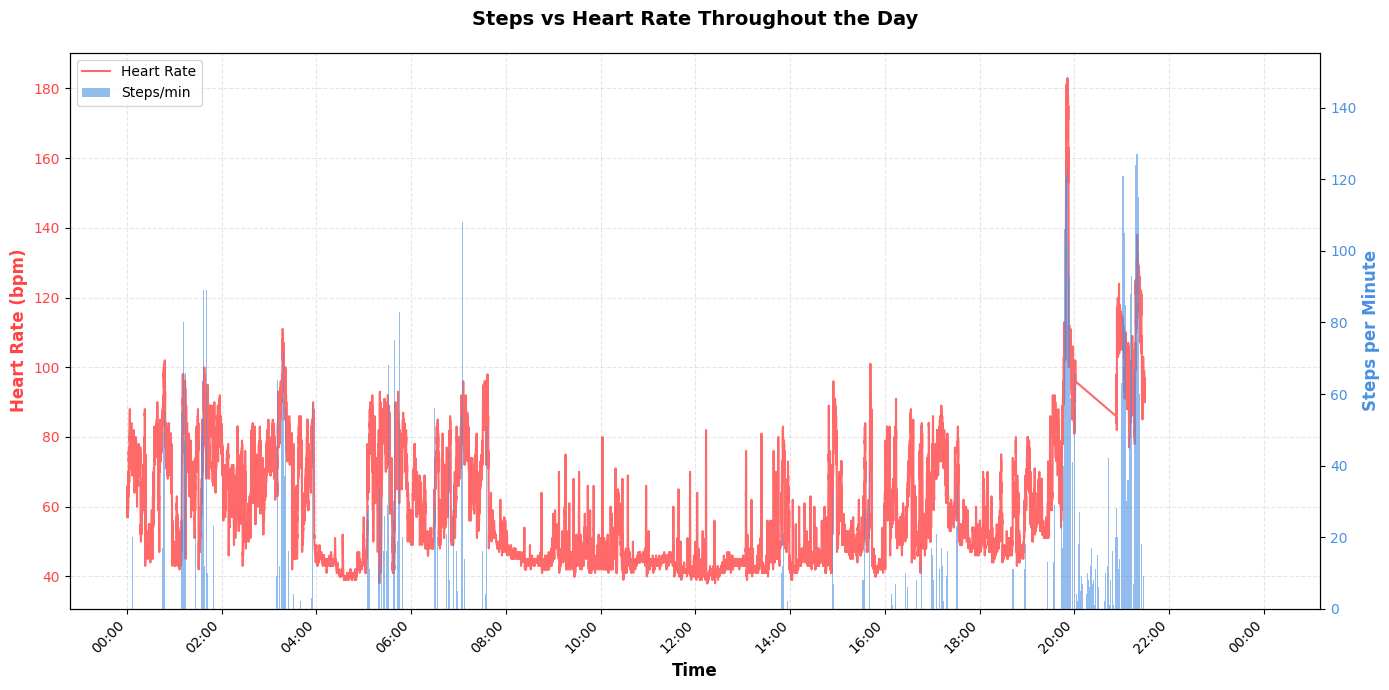

In [23]:
fig1 = plot_steps_vs_heart_rate(df_hr_intra, df_steps_intra)
plt.show()

In [24]:
# ============================================================================
# OPTION 2: Step Goals & Progress
# ============================================================================
def plot_step_goals_progress(df_steps_intra, daily_goal=10000):
    """
    Show cumulative steps throughout the day with goal milestones
    
    Parameters:
    - df_steps_intra: Intraday steps dataframe
    - daily_goal: Target steps for the day (default 10000)
    """
    # Convert to London timezone
    df_steps = df_steps_intra.copy()
    df_steps['time'] = df_steps['time'].dt.tz_convert('Europe/London')
    
    # Calculate cumulative steps
    df_steps['cumulative_steps'] = df_steps['value'].cumsum()
    
    # Get final step count
    total_steps = df_steps['cumulative_steps'].iloc[-1]
    goal_percentage = (total_steps / daily_goal) * 100
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), 
                                    gridspec_kw={'height_ratios': [2, 1]})
    
    # ========================================================================
    # Panel 1: Cumulative Steps Progress
    # ========================================================================
    
    # Plot cumulative steps
    ax1.plot(df_steps['time'], df_steps['cumulative_steps'], 
             color='#4a90e2', linewidth=2.5, label='Cumulative Steps')
    
    # Fill area under curve
    ax1.fill_between(df_steps['time'], df_steps['cumulative_steps'], 
                     alpha=0.3, color='#4a90e2')
    
    # Add goal line
    ax1.axhline(daily_goal, color='#ff6b6b', linestyle='--', 
               linewidth=2, label=f'Daily Goal ({daily_goal:,})', alpha=0.8)
    
    # Add milestone lines
    milestones = [2500, 5000, 7500]
    for milestone in milestones:
        if milestone < daily_goal:
            ax1.axhline(milestone, color='gray', linestyle=':', 
                       linewidth=1, alpha=0.4)
            ax1.text(df_steps['time'].iloc[-1], milestone, 
                    f'{milestone:,}', fontsize=9, 
                    va='center', ha='right', alpha=0.6)
    
    # Highlight if goal reached
    if total_steps >= daily_goal:
        goal_time = df_steps[df_steps['cumulative_steps'] >= daily_goal]['time'].iloc[0]
        ax1.axvline(goal_time, color='green', linestyle='--', 
                   linewidth=2, alpha=0.5, label=f'Goal Reached!')
        ax1.scatter([goal_time], [daily_goal], color='green', 
                   s=200, zorder=5, marker='*')
    
    ax1.set_ylabel('Cumulative Steps', fontsize=12, fontweight='bold')
    ax1.set_title(f'Daily Step Progress: {total_steps:,} steps ({goal_percentage:.1f}% of goal)', 
                 fontsize=14, fontweight='bold')
    ax1.grid(True, alpha=0.3, linestyle='--')
    ax1.legend(loc='upper left', fontsize=10)
    
    # Format x-axis
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M', tz='Europe/London'))
    ax1.xaxis.set_major_locator(mdates.HourLocator(interval=2))
    
    # ========================================================================
    # Panel 2: Steps per Minute (Activity Bursts)
    # ========================================================================
    
    # Plot steps per minute
    ax2.bar(df_steps['time'], df_steps['value'], 
           width=0.0007, color='#4a90e2', alpha=0.6)
    
    # Add threshold line for "active" minutes (e.g., 100+ steps/min)
    active_threshold = 100
    ax2.axhline(active_threshold, color='orange', linestyle='--', 
               linewidth=1.5, alpha=0.7, 
               label=f'Active Threshold ({active_threshold} steps/min)')
    
    ax2.set_ylabel('Steps per Minute', fontsize=12, fontweight='bold')
    ax2.set_xlabel('Time', fontsize=12, fontweight='bold')
    ax2.grid(True, alpha=0.3, linestyle='--', axis='y')
    ax2.legend(loc='upper left', fontsize=10)
    
    # Format x-axis
    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M', tz='Europe/London'))
    ax2.xaxis.set_major_locator(mdates.HourLocator(interval=2))
    plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    plt.tight_layout()
    return fig

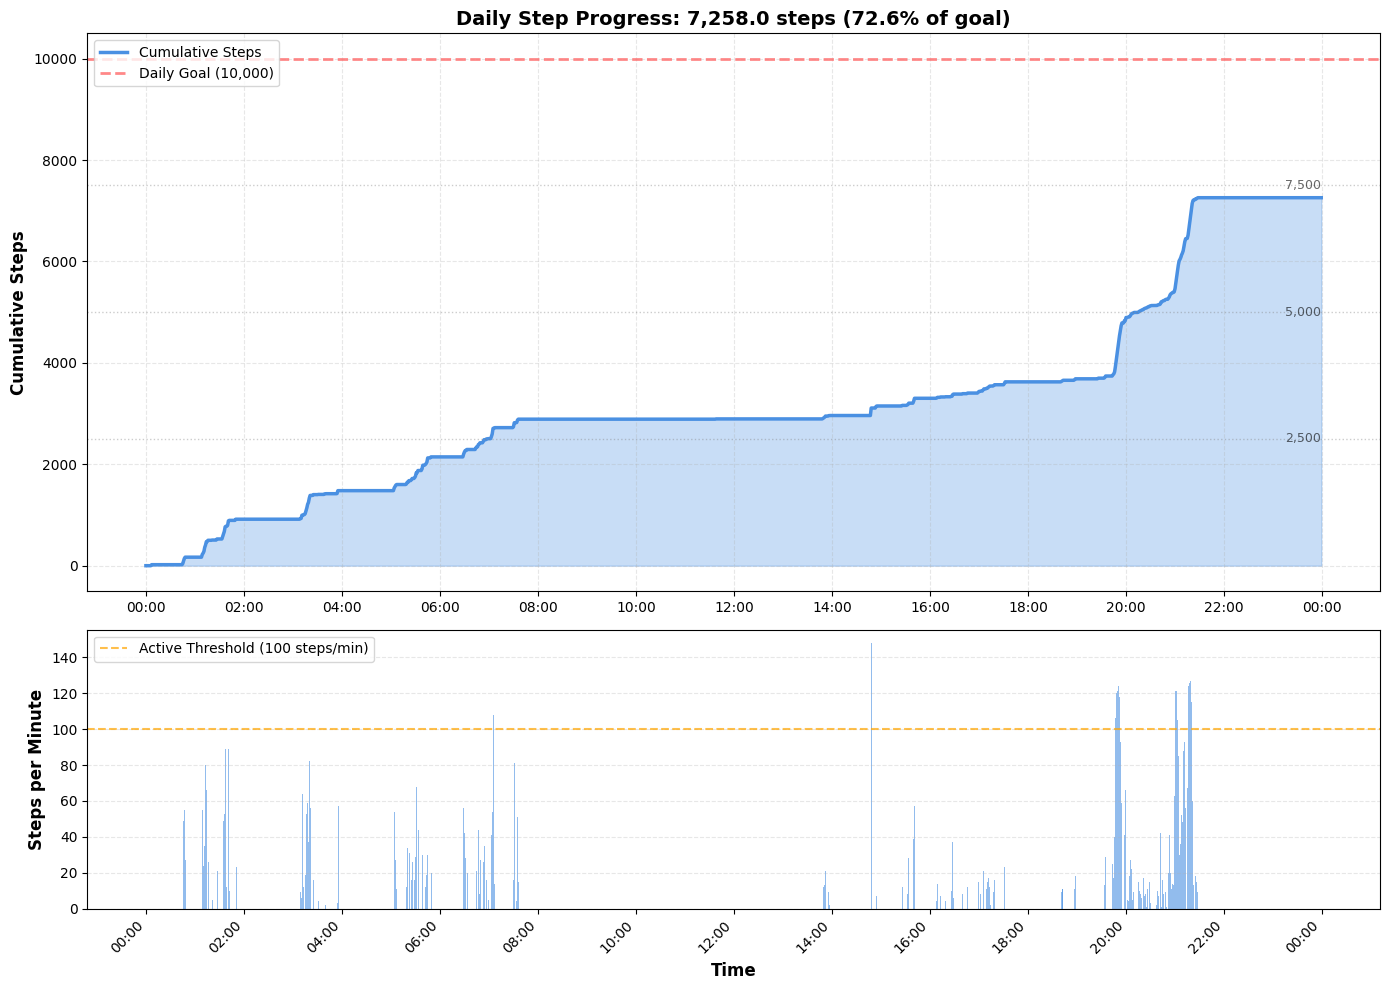

In [25]:
fig2 = plot_step_goals_progress(df_steps_intra, daily_goal=10000)
plt.show()

In [26]:
# ============================================================================
# BONUS: Activity Intensity Heatmap
# ============================================================================
def plot_hourly_activity_heatmap(df_steps_intra):
    """
    Show hourly activity levels as a heatmap-style bar chart
    """
    # Convert to London timezone
    df_steps = df_steps_intra.copy()
    df_steps['time'] = df_steps['time'].dt.tz_convert('Europe/London')
    
    # Extract hour from time
    df_steps['hour'] = df_steps['time'].dt.hour
    
    # Calculate steps per hour
    hourly_steps = df_steps.groupby('hour')['value'].sum().reset_index()
    hourly_steps.columns = ['hour', 'steps']
    
    # Ensure all 24 hours are present
    all_hours = pd.DataFrame({'hour': range(24)})
    hourly_steps = all_hours.merge(hourly_steps, on='hour', how='left').fillna(0)
    
    fig, ax = plt.subplots(figsize=(14, 6))
    
    # Create color map based on activity level
    max_steps = hourly_steps['steps'].max()
    colors = plt.cm.YlOrRd(hourly_steps['steps'] / max_steps)
    
    # Plot bars
    bars = ax.bar(hourly_steps['hour'], hourly_steps['steps'], 
                  color=colors, edgecolor='black', linewidth=0.5)
    
    # Add value labels on top of bars
    for bar, steps in zip(bars, hourly_steps['steps']):
        height = bar.get_height()
        if height > 0:
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{int(steps)}', ha='center', va='bottom', fontsize=9)
    
    ax.set_xlabel('Hour of Day', fontsize=12, fontweight='bold')
    ax.set_ylabel('Total Steps', fontsize=12, fontweight='bold')
    ax.set_title('Hourly Activity Distribution', fontsize=14, fontweight='bold')
    ax.set_xticks(range(24))
    ax.set_xticklabels([f'{h:02d}:00' for h in range(24)], rotation=45, ha='right')
    ax.grid(True, alpha=0.3, linestyle='--', axis='y')
    
    plt.tight_layout()
    return fig

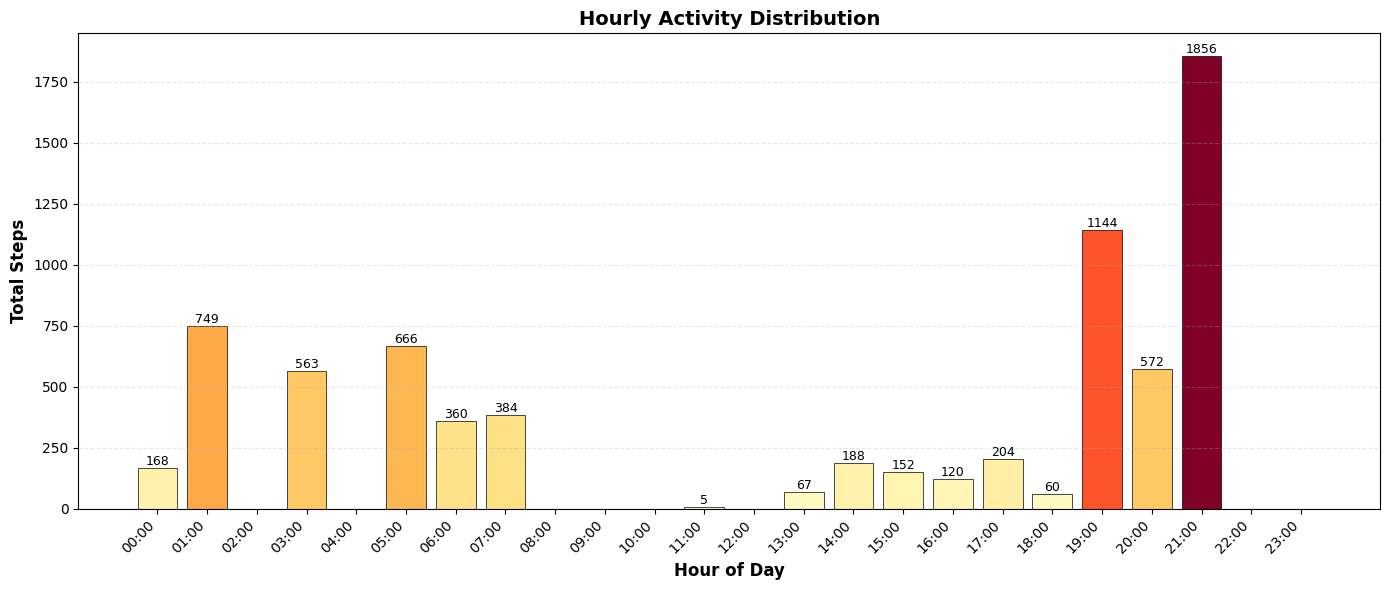

In [27]:
# Bonus: Hourly Activity Heatmap
fig3 = plot_hourly_activity_heatmap(df_steps_intra)
plt.show()